# Heterogeneous GNN

This notebook contains the code for the heterogeneous GNN training on pytorch graph dataset. 

In [24]:
# Torch
import torch
from torch_geometric.data import HeteroData, DataLoader, Dataset
from torch_geometric.nn import RGCNConv, global_mean_pool
from torch_geometric.nn import SAGEConv, to_hetero, GCNConv
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, GraphConv, Linear
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import trim_to_layer
from torch_geometric.loader import DataLoader

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# Misc
import os
import time
from math import ceil


# Path constants
PATH_GRAPH_DATA = '../../data/graph-dataset/semester-2/hetero-graph/merged-32/'
PATH_MODELS = '../../model/gnn/'


# Inferno dataset model
class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

----
## Read datasets

In this part, the necessary datasets for the training are handled, including reading, mixing and shuffling them in order to vary the data.

In [2]:
file_name_1 = "1000-1001-1002-1003-1004-1005-1006-1007-1008-1009-1010-1011-1012-1013-1014-1015-1016-1017-1018-1019-1020-1021-1022-1023-1024-1025-1026-1027-1028-1029-1030-1031.pt"
dataset_1 = torch.load(PATH_GRAPH_DATA + file_name_1)
print("dataset_1 loaded")

file_name_2 = "1032-1033-1034-1035-1036-1037-1038-1039-1040-1041-1042-1043-1044-1045-1046-1047-1048-1049-1050-1051-1052-1053-1054-1055-1056-1057-1058-1059-1060-1061-1062-1063.pt"
dataset_2 = torch.load(PATH_GRAPH_DATA + file_name_2)
print("dataset_2 loaded")

file_name_3 = "1064-1065-1066-1067-1068-1069-1070-1071-1072-1073-1074-1075-1076-1077-1078-1079-1080-1081-1082-1083-1084-1085-1086-1087-1088-1089-1090-1091-1092-1093-1094-1095.pt"
dataset_3 = torch.load(PATH_GRAPH_DATA + file_name_3)
print("dataset_3 loaded")

file_name_4 = "1096-1097-1098-1099-1100-1101-1102-1103-1104-1105-1106-1107-1108-1109-1110-1111-1112-1113-1114-1115-1116-1117-1118-1119-1120-1121-1122-1123-1124-1125-1126-1127.pt"
dataset_4 = torch.load(PATH_GRAPH_DATA + file_name_4)
print("dataset_4 loaded")

file_name_5 = "1128-1129-1130-1131-1132-1133.pt"
dataset_5 = torch.load(PATH_GRAPH_DATA + file_name_5)
print("dataset_5 loaded")

dataset_1 loaded
dataset_2 loaded
dataset_3 loaded
dataset_4 loaded
dataset_5 loaded


Shuffle the datasets

In [3]:
torch.manual_seed(42)

shuffled_dataset_1 = dataset_1[torch.randperm(len(dataset_1))]
shuffled_dataset_2 = dataset_2[torch.randperm(len(dataset_2))]
shuffled_dataset_3 = dataset_3[torch.randperm(len(dataset_3))]
shuffled_dataset_4 = dataset_4[torch.randperm(len(dataset_4))]
shuffled_dataset_5 = dataset_5[torch.randperm(len(dataset_5))]

In [10]:
mixing_batch_size = 50000
shuffled_dataset = InfernoDataset(
                        shuffled_dataset_1[:mixing_batch_size] + \
                        shuffled_dataset_2[:mixing_batch_size] + \
                        shuffled_dataset_3[:mixing_batch_size] + \
                        shuffled_dataset_4[:mixing_batch_size] + \
                        shuffled_dataset_5[:25000] \
                   )

torch.manual_seed(42)
shuffled_dataset = shuffled_dataset[torch.randperm(len(dataset_1))]

----
## Heterogeneous GNN

In this section, the heterogeneous GNN model is defined as well as the essentials for the training process, including data loaders, loss metrics, optimizer, the training / validation / test functions along with the plotting one to make interpretation easy.

In [11]:
class HeterogeneousGNN(torch.nn.Module):

    def __init__(self, hidden_channels, conv_layers, dense_layers, edge_types):
        super().__init__()

        torch.manual_seed(42)

        self.convs = torch.nn.ModuleList()
        for layernum in range(conv_layers):
            conv = HeteroConv({
                    edge_type: SAGEConv((-1, -1), hidden_channels)
                    for edge_type in edge_types
                }, aggr='mean')
            self.convs.append(conv)

        self.linear = Linear(-1, dense_layers[0]['input_neuron_num'])
        
        # Create dense layers based on the 'dense_layers' parameter
        dense_layers_container = []
        for layer_config in dense_layers:

            if layer_config['dropout'] == 0:
                # Add the first layer manually because it has a different input size
                dense_layers_container.append(torch.nn.Linear(layer_config['input_neuron_num'], layer_config['neuron_num']))
                
                # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                if layer_config['activation_function'] is not None:
                    dense_layers_container.append(layer_config['activation_function'])

                # Add the rest of the layers (if there are any)
                for _ in range(layer_config['num_of_layers'] - 1):
                    dense_layers_container.append(torch.nn.Linear(layer_config['neuron_num'], layer_config['neuron_num']))

                    # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                    if layer_config['activation_function'] is not None:
                        dense_layers_container.append(layer_config['activation_function'])
            else:
                dense_layers_container.append(torch.nn.Dropout(layer_config['dropout']))
        
        self.dense = torch.nn.Sequential(*dense_layers_container)
        

    def forward(self, x_dict, edge_index_dict, y):
      graph_data = torch.tensor([
          y['match_id'],
          y['roundNum'],
          y['time_remaining'],
          y['tScore'],
          y['ctScore'],
          y['CT_aliveNum'],
          y['T_aliveNum'],
          y['CT_equipmentValue'],
          y['T_equipmentValue'],
          y['is_bomb_being_planted'],
          y['is_bomb_planted_at_A_site'],
          y['is_bomb_planted_at_B_site'],
          y['is_bomb_being_defused'],
          y['is_bomb_defused'],
          y['bomb_mx_pos1'],
          y['bomb_mx_pos2'],
          y['bomb_mx_pos3'],
          y['bomb_mx_pos4'],
          y['bomb_mx_pos5'],
          y['bomb_mx_pos6'],
          y['bomb_mx_pos7'],
          y['bomb_mx_pos8'],
          y['bomb_mx_pos9'],
      ]).to('cuda')

      edge_index_dict = {key: value.to(torch.int64) for key, value in edge_index_dict.items()}

      for conv in self.convs:
          temp = conv(x_dict, edge_index_dict)
          x_dict['map'] = torch.cat([x_dict['map'][:,:5],temp['map']],dim=1)
          x_dict = {key: x.relu() for key, x in x_dict.items()}

      # With flattem
      x = torch.cat([torch.flatten(x_dict['player']), torch.flatten(x_dict['map']), torch.flatten(graph_data)])

      # Global mean pool
      #one = global_mean_pool(x_dict['player'],None)
      #two = global_mean_pool(x_dict['map'], None)
      #x = torch.cat([torch.flatten(x_dict['player']), torch.flatten(two)])

      x = self.linear(x)
      x = self.dense(x)
      return x

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 3,
        "input_neuron_num": 2048,
        "neuron_num": 2048,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 3,
        "input_neuron_num": 2048,
        "neuron_num": 512,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "input_neuron_num": 512,
        "neuron_num": 64,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "input_neuron_num": 64,
        "neuron_num": 16,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "input_neuron_num": 16,
        "neuron_num": 4,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "input_neuron_num": 4,
        "neuron_num": 1,
        "activation_function": None
    },
]
model = HeterogeneousGNN(hidden_channels=30, conv_layers=10, dense_layers=dense_layers, edge_types=shuffled_dataset[0].edge_types)

In [20]:
train_loader = DataLoader(shuffled_dataset[:20000], batch_size=1, shuffle=False)
val_loader = DataLoader(shuffled_dataset[20000:40000], batch_size=1, shuffle=False)
test_loader = DataLoader(shuffled_dataset[40000:60000], batch_size=1, shuffle=False)

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 2048,
        "input_neuron_num": 2048,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 512,
        "input_neuron_num": 2048,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 64,
        "input_neuron_num": 512,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.5,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 16,
        "input_neuron_num": 64,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 4,
        "input_neuron_num": 16,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 4,
        "activation_function": None
    },
]

model = HeterogeneousGNN(hidden_channels=15, conv_layers=10, dense_layers=dense_layers, edge_types=shuffled_dataset[0].edge_types).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.02)
loss_function = torch.nn.BCEWithLogitsLoss()


with torch.no_grad():  # Initialize lazy modules.
     data = shuffled_dataset[0].to('cuda')
     out = model(data.x_dict, data.edge_index_dict, data.y)
     print(torch.sigmoid(out))

     
print('params:', sum(p.numel() for p in model.parameters()))
print('trainable:', sum(p.numel() for p in model.parameters() if p.requires_grad))

tensor([0.3634], device='cuda:0')
params: 19421500
trainable: 19421500


In [21]:
def epoch_result_visualization(
    epochs,
    epoch,
    epoch_start,
    epoch_end,
    train_avg_loss,
    val_metrics,
    train_losses,
    val_losses, 
    accuracies, 
    precisions, 
    recalls, 
    f1_scores
):
    val_avg_loss = val_metrics[0]
    accuracy = val_metrics[1]
    precision = val_metrics[2]
    recall = val_metrics[3]
    f1 = val_metrics[4]
    cm = val_metrics[5]
    cm_normalized = val_metrics[6]
    fpr, tpr = val_metrics[7], val_metrics[8]

    print("-------------------------------------------------------------------------------------------\n"
         f"                                     Epoch {epoch}\n"
          "-------------------------------------------------------------------------------------------\n"
          "Time: \n"
         f"   -Start time: {epoch_start} \n"
         f"   -End time: {epoch_end}s \n"
         f"   -Duration: {epoch_end - epoch_start}s \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Training results:\n"
         f"   - Average loss: {train_avg_loss:.4f} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Validation results: \n"
         f"   - Average loss: {val_avg_loss} \n"
         f"   - Accuracy: {accuracy} \n"
         f"   - Precision: {precision} \n"
         f"   - Recall: {recall} \n"
         f"   - F1: {f1} \n"
          "   - Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")
    
    # ----------------------------------------
    # Confusion matrix & ROC/AUC visualization
    # ----------------------------------------

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(f'Epoch {epoch} - Validation scores', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # Normalized Confusion Matrix
    im = axs[1].matshow(cm_normalized, cmap='Blues', alpha=0.6)
    axs[1].set_aspect('equal')
    axs[1].set_title('Normalized confusion matrix', fontsize=10, y=1)
    axs[1].set_xlabel('Predicted', fontsize=8)
    # Add numbers to the normalized confusion matrix
    for (i, j), val in np.ndenumerate(cm_normalized):
        axs[1].text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[1].set_xticks([0, 1])
    axs[1].set_xticklabels([0, 1])
    axs[1].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('False Positive Rate', fontsize=8)
    axs[2].set_ylabel('True Positive Rate', fontsize=8)
    axs[2].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[2].legend(loc="lower right", fontsize=8)
    axs[2].set_aspect('equal')


    plt.tight_layout()
    plt.show()



    # ----------------------------------------
    # Metrics visualization
    # ----------------------------------------

    fig, axs = plt.subplots(2, 3, figsize=(8, 4.5))
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=12)

    epochs_range = np.arange(0, epoch + 1)

    def plot_metric(ax, data, title, ylabel, color):
        if len(data) == 1:
            ax.scatter(epochs_range, data, s=10, c=color)
        else:
            ax.plot(epochs_range, data, marker='o', linestyle='-', color=color)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Epoch', fontsize=8)
        ax.set_ylabel(ylabel, fontsize=8)
        ax.set_xticks(epochs_range)
        ax.set_xlim(-1, epochs)
        if 'Loss' not in title:
            ax.set_ylim(0, 1)
        ax.grid(True)

    plot_metric(axs[0, 0], train_losses, 'Train Loss', 'Loss', 'cornflowerblue')
    plot_metric(axs[0, 1], val_losses, 'Validation Loss', 'Loss', 'darkorange')
    plot_metric(axs[0, 2], accuracies, 'Accuracy', 'Accuracy', 'limegreen')
    plot_metric(axs[1, 0], precisions, 'Precision', 'Precision', 'red')
    plot_metric(axs[1, 1], recalls, 'Recall', 'Recall', 'teal')
    plot_metric(axs[1, 2], f1_scores, 'F1 Score', 'F1 Score', 'black')

    plt.tight_layout()
    plt.show()



def train(epochs):

    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch in range(epochs):

        epoch_start = time.time()
        model.train()
        total_loss = 0
        
        for data in train_loader:  # Iterate in batches over the training dataset.
            data = data.to('cuda')
            optimizer.zero_grad()  # Clear gradients.
            
            out = model(data.x_dict, data.edge_index_dict, data.y).float()  # Perform a single forward pass.
            target = torch.tensor(data.y['CT_winsRound']).float().to('cuda')  # Assuming target is stored in data.y

            loss = loss_function(out, target)  # Compute the loss.
            loss.backward()  # Backpropagate.
            optimizer.step()  # Update model parameters.

            total_loss += loss.item()  # Accumulate the loss.


        train_avg_loss = total_loss / len(train_loader)
        val_metrics = validate(val_loader)  # Validate the model on validation dataset.
        epoch_end = time.time()

        val_avg_loss = val_metrics[0]
        accuracy = val_metrics[1]
        precision = val_metrics[2]
        recall = val_metrics[3]
        f1 = val_metrics[4]

        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        epoch_result_visualization(epochs, epoch, epoch_start, epoch_end, train_avg_loss, val_metrics, train_losses, val_losses, accuracies, precisions, recalls, f1_scores)

        




def validate(val_loader):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in val_loader:  # Iterate in batches over the validation dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y).float()
            target = torch.tensor(data.y['CT_winsRound']).float().to('cuda')

            loss = loss_function(out, target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = (torch.sigmoid(out) > 0.5).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(targets_all, predictions_all)
    precision = precision_score(targets_all, predictions_all)
    recall = recall_score(targets_all, predictions_all)
    f1 = f1_score(targets_all, predictions_all)
    cm = confusion_matrix(targets_all, predictions_all)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    return avg_loss, accuracy, precision, recall, f1, cm, cm_normalized, fpr, tpr



def test(test_loader):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in test_loader:  # Iterate in batches over the test dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y).float()
            target = torch.tensor(data.y['CT_winsRound']).float().to('cuda')

            loss = loss_function(out, target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = (torch.sigmoid(out) > 0.5).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(targets_all, predictions_all)
    precision = precision_score(targets_all, predictions_all)
    recall = recall_score(targets_all, predictions_all)
    f1 = f1_score(targets_all, predictions_all)
    cm = confusion_matrix(targets_all, predictions_all)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    print("-------------------------------------------------------------------------------------------\n"
          "                                      Test Results\n"                                     
          "-------------------------------------------------------------------------------------------\n"
         f"Average loss: {avg_loss} \n"
         f"Accuracy: {accuracy} \n"
         f"Precision: {precision} \n"
         f"Recall: {recall} \n"
         f"F1: {f1} \n"
          "Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle('Test results', fontsize=12)

    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

    # Normalized Confusion Matrix
    im = axs[1].matshow(cm_normalized, cmap='Blues', alpha=0.6)
    axs[1].set_aspect('equal')
    axs[1].set_title('Normalized confusion matrix', fontsize=10, y=1)
    axs[1].set_xlabel('Predicted', fontsize=8)
    for (i, j), val in np.ndenumerate(cm_normalized):
        axs[1].text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=10, color='black')
    axs[1].set_xticks([0, 1])
    axs[1].set_xticklabels([0, 1])
    axs[1].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

    # ROC/AUC Curve
    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('False Positive Rate', fontsize=8)
    axs[2].set_ylabel('True Positive Rate', fontsize=8)
    axs[2].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[2].legend(loc="lower right", fontsize=8)
    axs[2].set_aspect('equal')

    plt.tight_layout()
    plt.show()

    return avg_loss, accuracy, precision, recall, f1, cm, cm_normalized, fpr, tpr



----
## Training

This is the part where the GNN is trained on the data

In [189]:
data.to('cpu')
model.to('cpu');

In [296]:
data.to('cuda')
model.to('cuda');

------------------------------------------------------------
                       Epoch 0
------------------------------------------------------------
Runtime: 633.9208629131317s 
Training results:
   - Average loss: 0.6823 
Validation results: 
     - Average loss: 0.6122226455865777 
     - Accuracy: 0.61785 
     - Precision: 0.7691945360339143 
     - Recall: 0.18586387434554974 
     - F1: 0.29938582821523513 
     - Confusion matrix & ROC/AUC: 



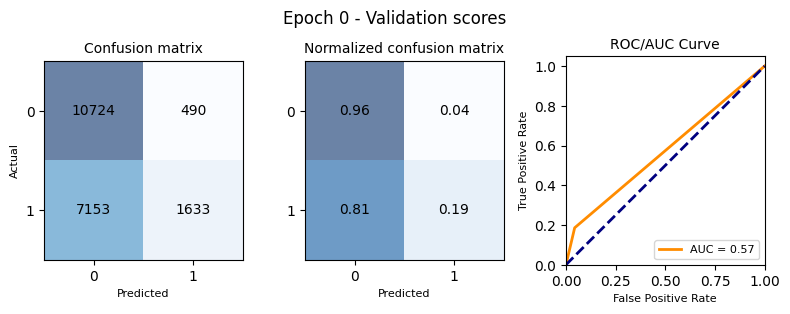

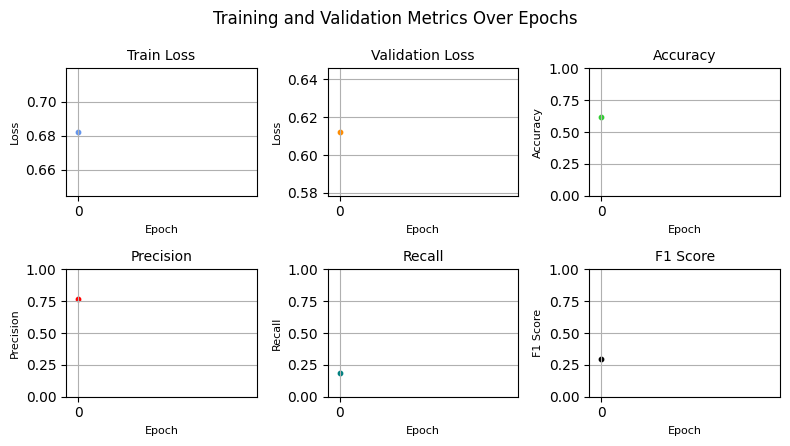

------------------------------------------------------------
                       Epoch 1
------------------------------------------------------------
Runtime: 637.6699478626251s 
Training results:
   - Average loss: 0.5784 
Validation results: 
     - Average loss: 0.5743119583706794 
     - Accuracy: 0.72155 
     - Precision: 0.7302132531844855 
     - Recall: 0.5806965627134077 
     - F1: 0.6469282951879795 
     - Confusion matrix & ROC/AUC: 



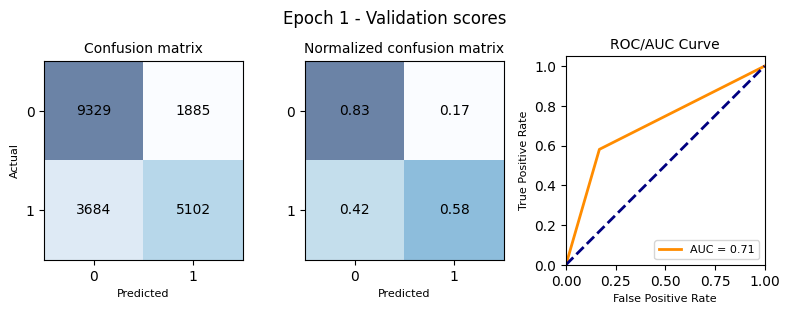

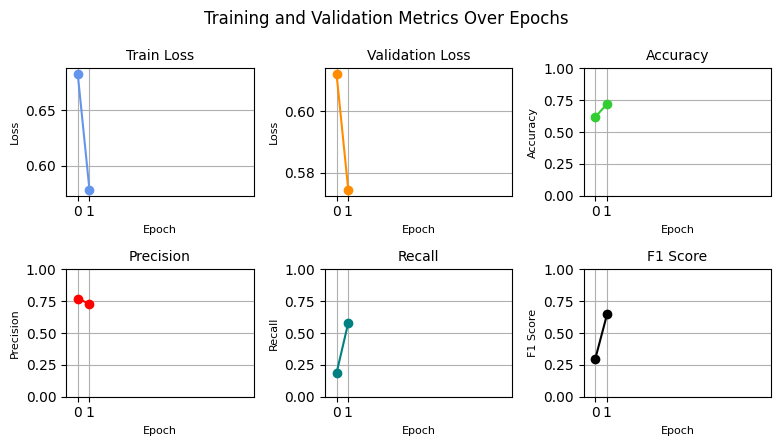

------------------------------------------------------------
                       Epoch 2
------------------------------------------------------------
Runtime: 638.9421079158783s 
Training results:
   - Average loss: 0.5403 
Validation results: 
     - Average loss: 0.5200450433444814 
     - Accuracy: 0.7308 
     - Precision: 0.6687834887874579 
     - Recall: 0.7671295242431141 
     - F1: 0.7145886344359627 
     - Confusion matrix & ROC/AUC: 



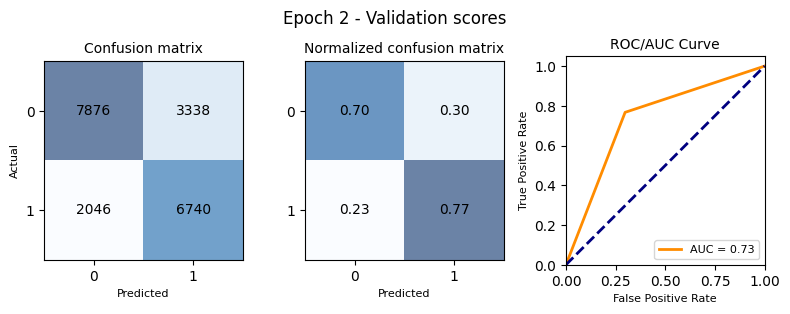

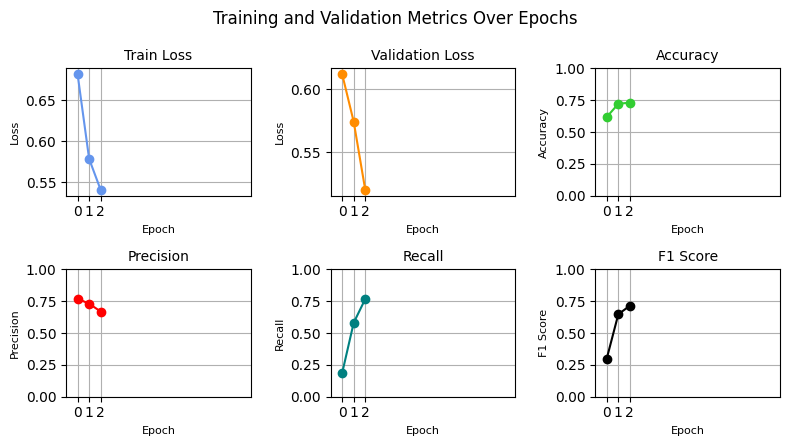

------------------------------------------------------------
                       Epoch 3
------------------------------------------------------------
Runtime: 636.6177821159363s 
Training results:
   - Average loss: 0.5223 
Validation results: 
     - Average loss: 0.5503770818077767 
     - Accuracy: 0.6781 
     - Precision: 0.887203166226913 
     - Recall: 0.30616890507625766 
     - F1: 0.4552377728888137 
     - Confusion matrix & ROC/AUC: 



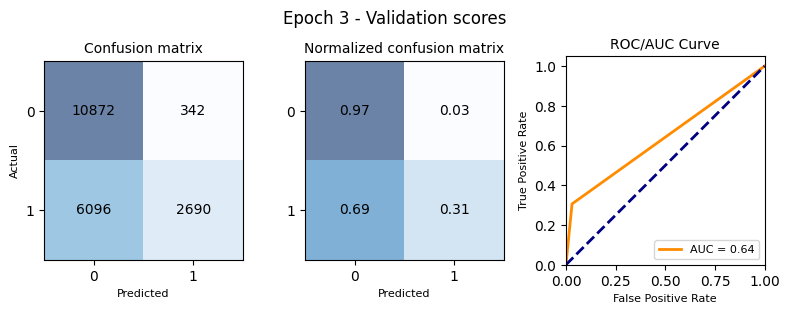

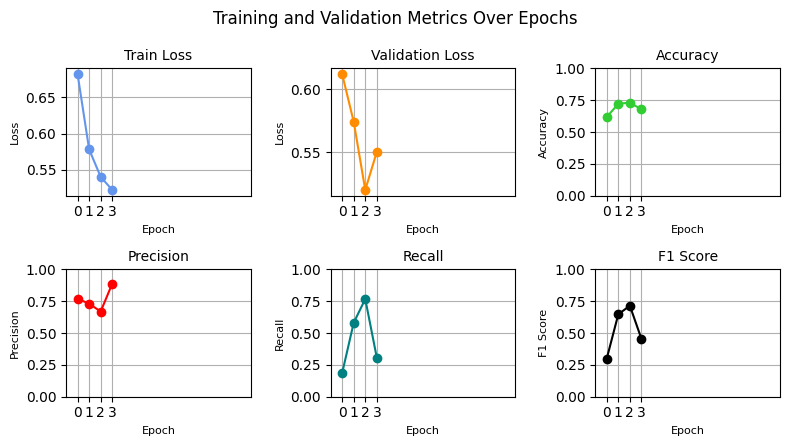

------------------------------------------------------------
                       Epoch 4
------------------------------------------------------------
Runtime: 622.5961985588074s 
Training results:
   - Average loss: 0.5044 
Validation results: 
     - Average loss: 0.5071971757109359 
     - Accuracy: 0.7153 
     - Precision: 0.8732496378561082 
     - Recall: 0.4116776690188937 
     - F1: 0.5595606435643564 
     - Confusion matrix & ROC/AUC: 



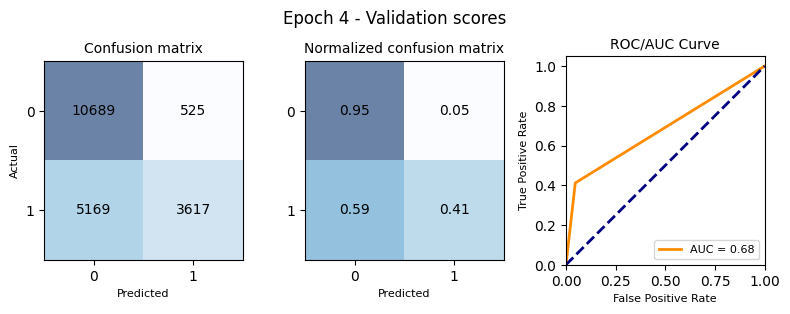

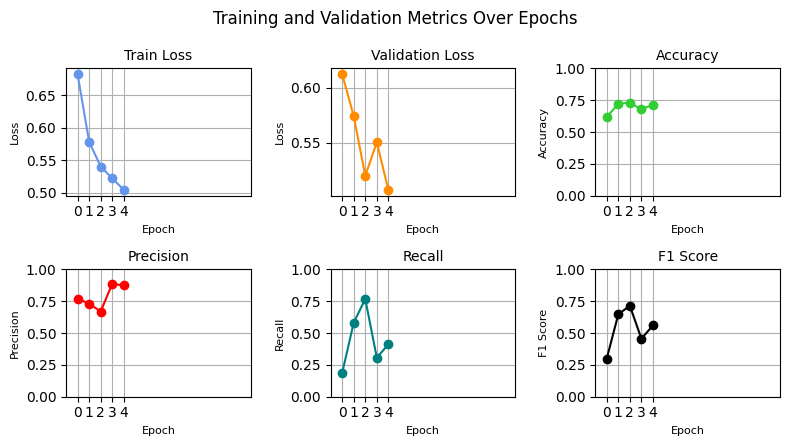

------------------------------------------------------------
                       Epoch 5
------------------------------------------------------------
Runtime: 644.7343945503235s 
Training results:
   - Average loss: 0.4763 
Validation results: 
     - Average loss: 0.5097214112538965 
     - Accuracy: 0.7013 
     - Precision: 0.7548024646611091 
     - Recall: 0.47404962440245846 
     - F1: 0.582354586129754 
     - Confusion matrix & ROC/AUC: 



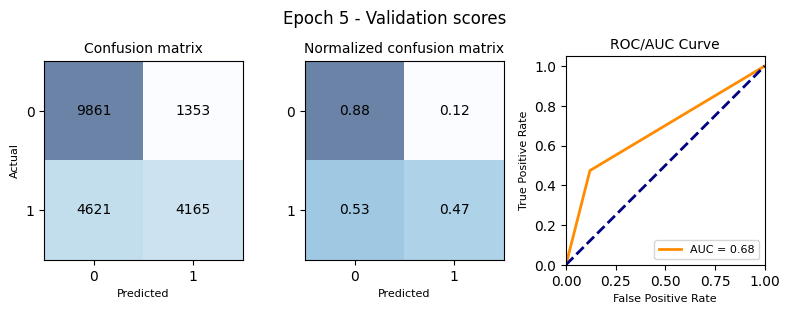

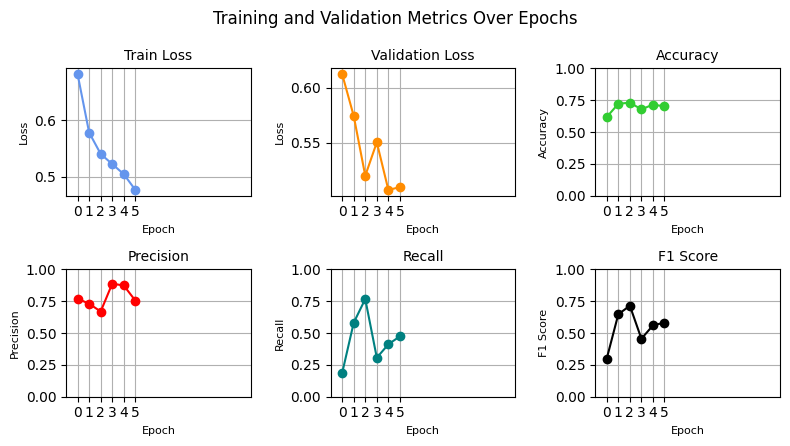

------------------------------------------------------------
                       Epoch 6
------------------------------------------------------------
Runtime: 642.9528315067291s 
Training results:
   - Average loss: 0.4615 
Validation results: 
     - Average loss: 0.5007245395022484 
     - Accuracy: 0.7333 
     - Precision: 0.882365972529907 
     - Recall: 0.45333485089915776 
     - F1: 0.5989473684210526 
     - Confusion matrix & ROC/AUC: 



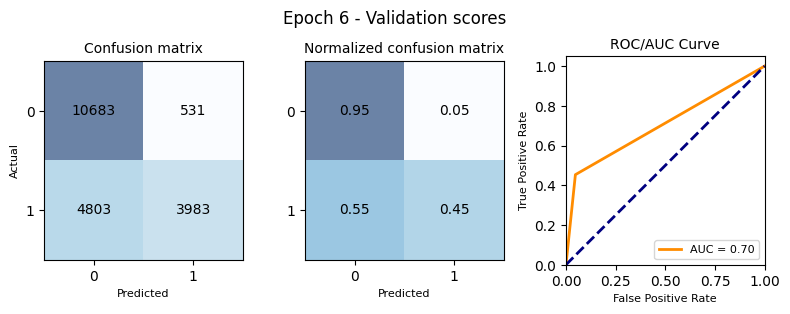

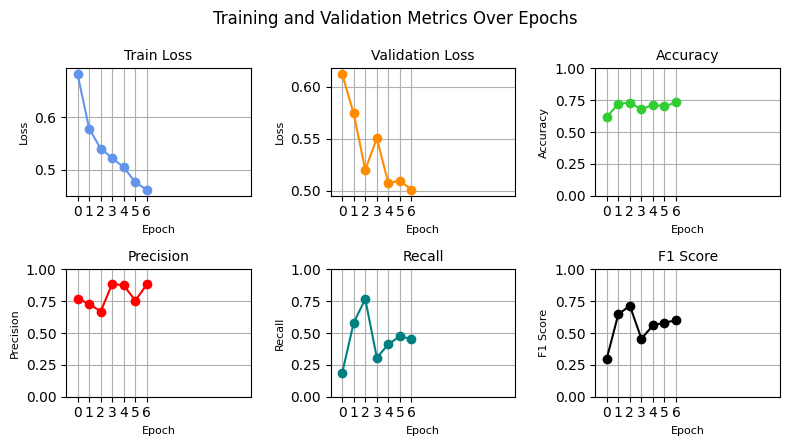

------------------------------------------------------------
                       Epoch 7
------------------------------------------------------------
Runtime: 641.461879491806s 
Training results:
   - Average loss: 0.4530 
Validation results: 
     - Average loss: 0.5035609191777538 
     - Accuracy: 0.72125 
     - Precision: 0.841523080195703 
     - Recall: 0.450261780104712 
     - F1: 0.5866389856899236 
     - Confusion matrix & ROC/AUC: 



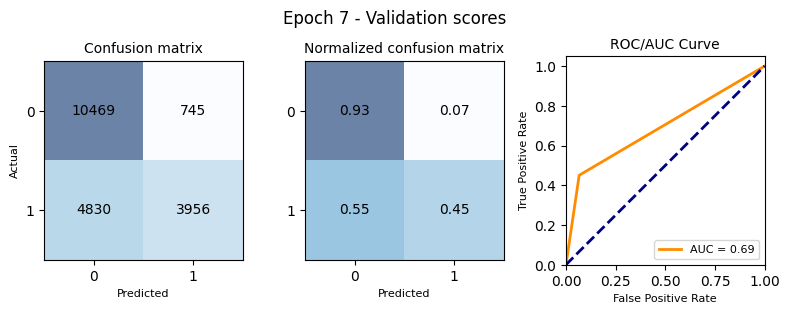

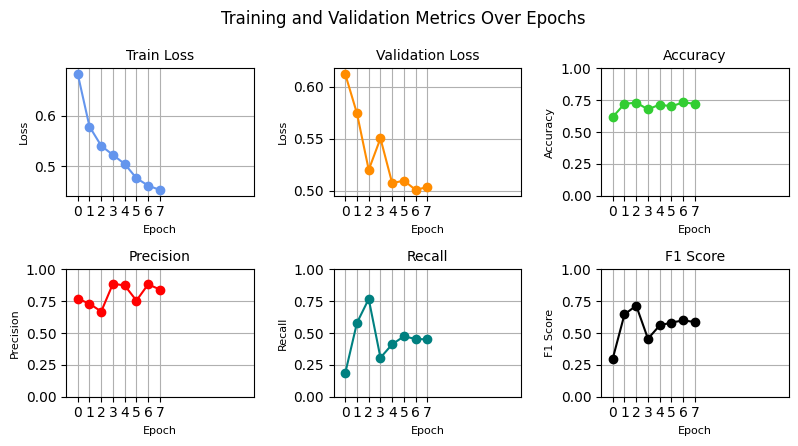

------------------------------------------------------------
                       Epoch 8
------------------------------------------------------------
Runtime: 614.3988599777222s 
Training results:
   - Average loss: 0.4384 
Validation results: 
     - Average loss: 0.4676254147915639 
     - Accuracy: 0.76525 
     - Precision: 0.778564619365382 
     - Recall: 0.6506942863646711 
     - F1: 0.7089094178188357 
     - Confusion matrix & ROC/AUC: 



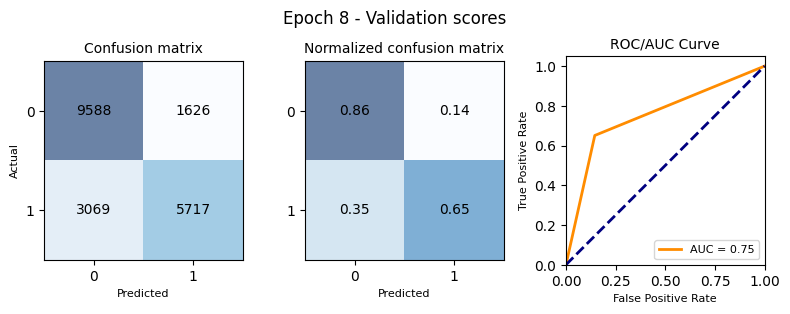

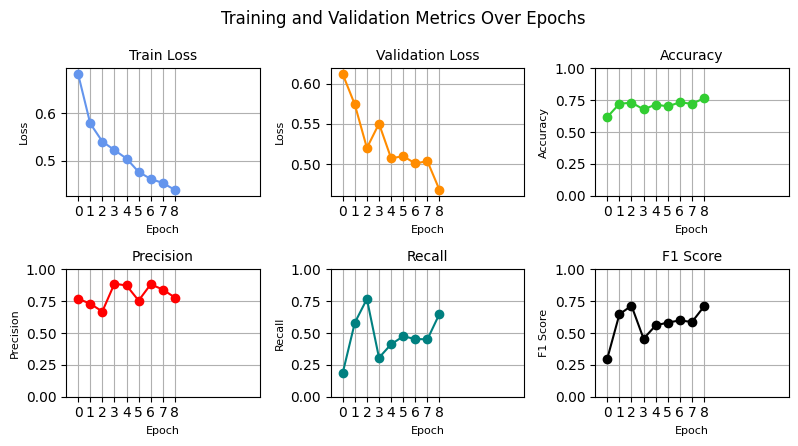

------------------------------------------------------------
                       Epoch 9
------------------------------------------------------------
Runtime: 605.6310293674469s 
Training results:
   - Average loss: 0.4318 
Validation results: 
     - Average loss: 0.50784399292452 
     - Accuracy: 0.7044 
     - Precision: 0.7416750756811302 
     - Recall: 0.5019348964261325 
     - F1: 0.5986967146348086 
     - Confusion matrix & ROC/AUC: 



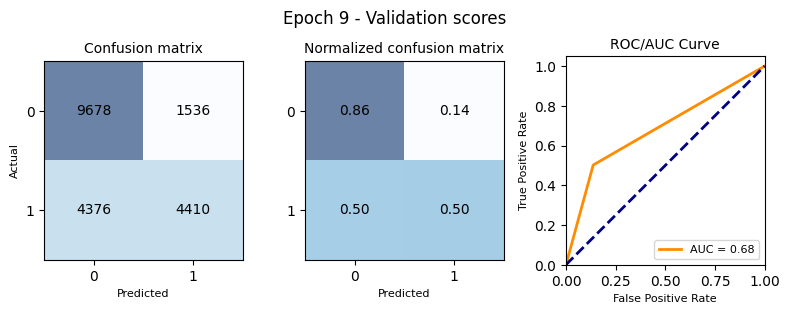

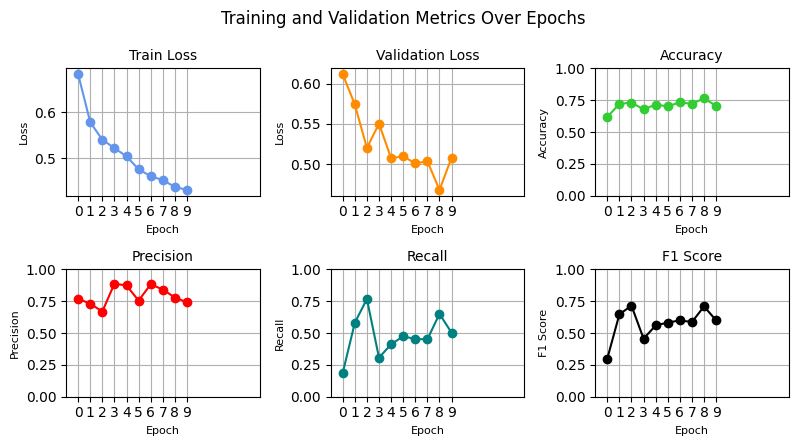

------------------------------------------------------------
                       Epoch 10
------------------------------------------------------------
Runtime: 623.6394510269165s 
Training results:
   - Average loss: 0.4190 
Validation results: 
     - Average loss: 0.5157501306158454 
     - Accuracy: 0.70305 
     - Precision: 0.7966242967284851 
     - Recall: 0.43512406100614615 
     - F1: 0.5628266470371733 
     - Confusion matrix & ROC/AUC: 



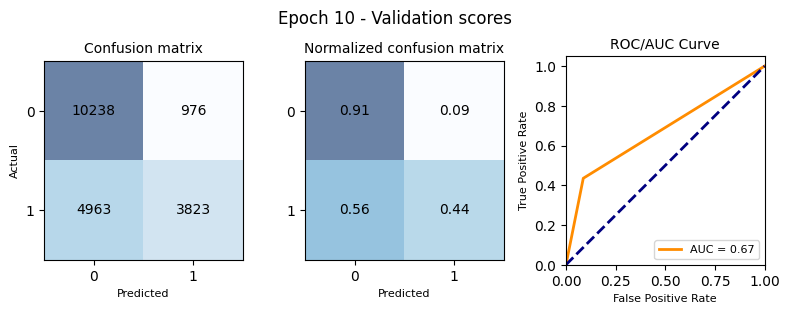

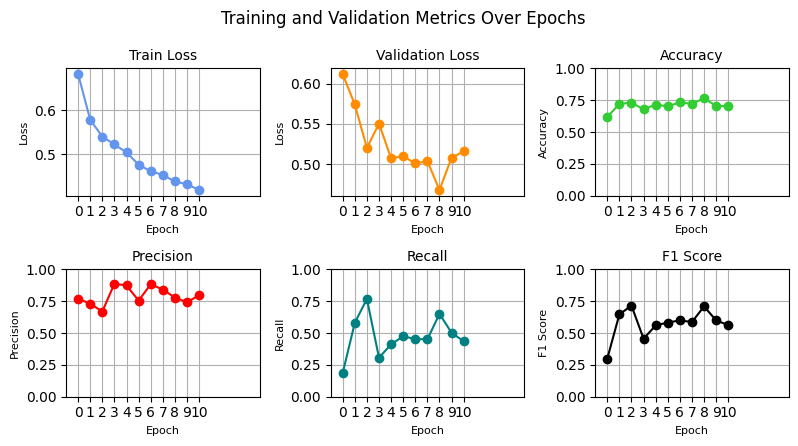

------------------------------------------------------------
                       Epoch 11
------------------------------------------------------------
Runtime: 598.1876871585846s 
Training results:
   - Average loss: 0.4162 
Validation results: 
     - Average loss: 0.5135952709457983 
     - Accuracy: 0.663 
     - Precision: 0.6835306781485468 
     - Recall: 0.43364443432733896 
     - F1: 0.5306406685236769 
     - Confusion matrix & ROC/AUC: 



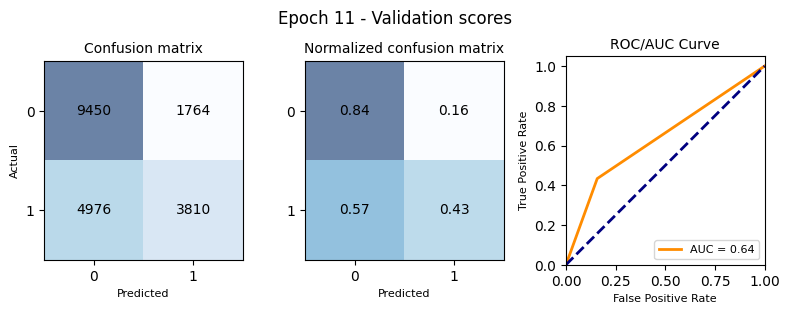

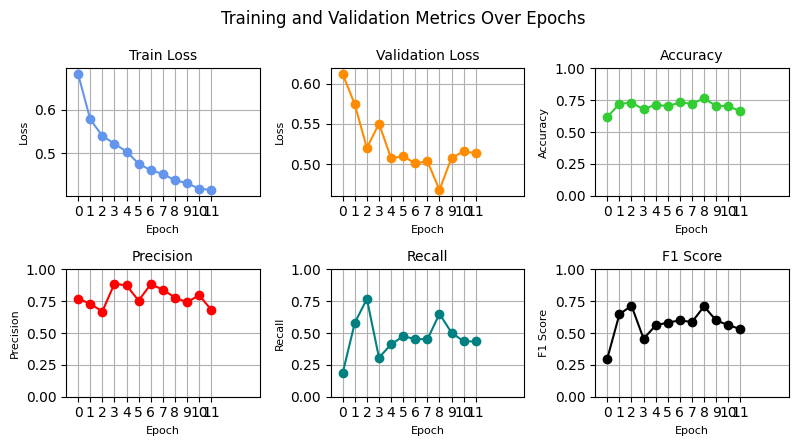

------------------------------------------------------------
                       Epoch 12
------------------------------------------------------------
Runtime: 653.0220324993134s 
Training results:
   - Average loss: 0.4143 
Validation results: 
     - Average loss: 0.45025438867157425 
     - Accuracy: 0.76845 
     - Precision: 0.7610908633907252 
     - Recall: 0.6892783974504895 
     - F1: 0.7234067968703339 
     - Confusion matrix & ROC/AUC: 



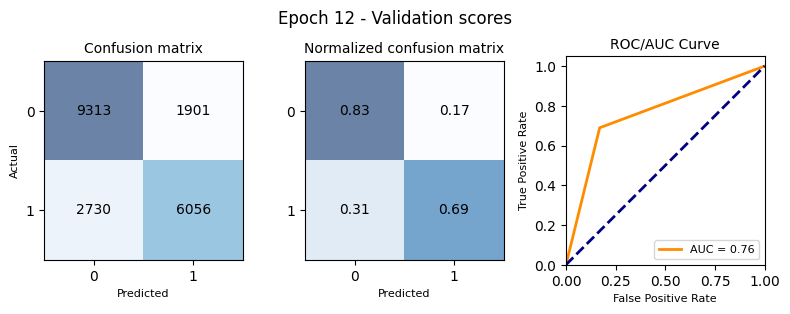

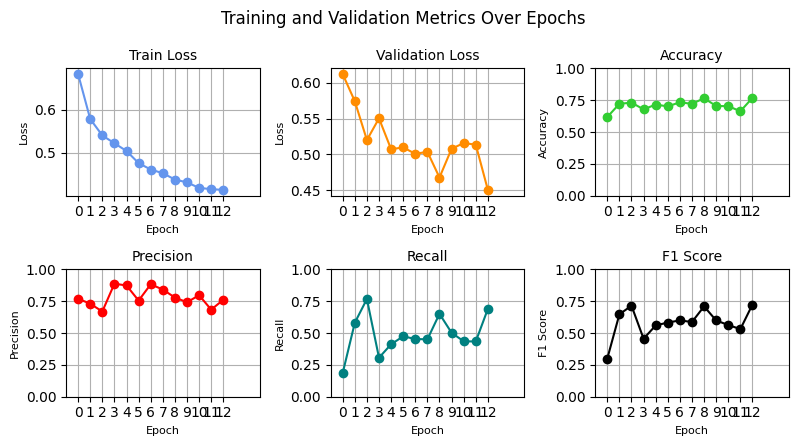

------------------------------------------------------------
                       Epoch 13
------------------------------------------------------------
Runtime: 631.7044050693512s 
Training results:
   - Average loss: 0.3995 
Validation results: 
     - Average loss: 0.47350194901738524 
     - Accuracy: 0.7594 
     - Precision: 0.7659973226238287 
     - Recall: 0.6512633735488277 
     - F1: 0.703986220472441 
     - Confusion matrix & ROC/AUC: 



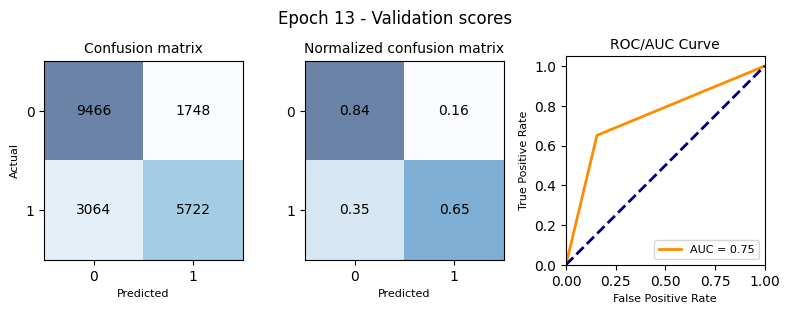

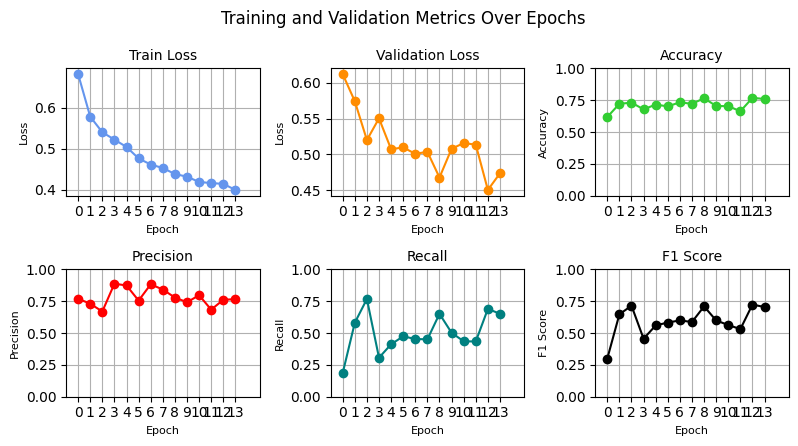

------------------------------------------------------------
                       Epoch 14
------------------------------------------------------------
Runtime: 637.5004415512085s 
Training results:
   - Average loss: 0.4239 
Validation results: 
     - Average loss: 0.4204747870855508 
     - Accuracy: 0.78365 
     - Precision: 0.7990610328638498 
     - Recall: 0.6780104712041884 
     - F1: 0.7335755187488455 
     - Confusion matrix & ROC/AUC: 



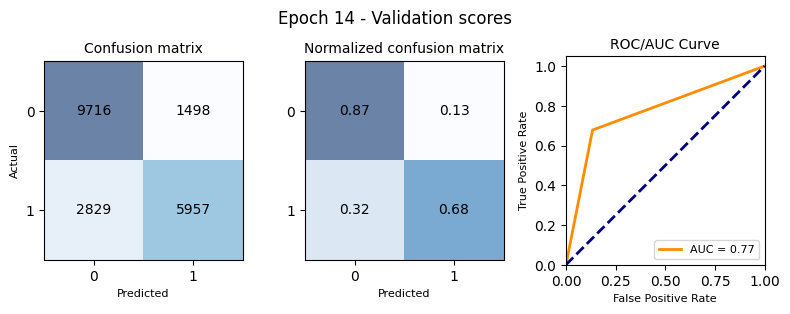

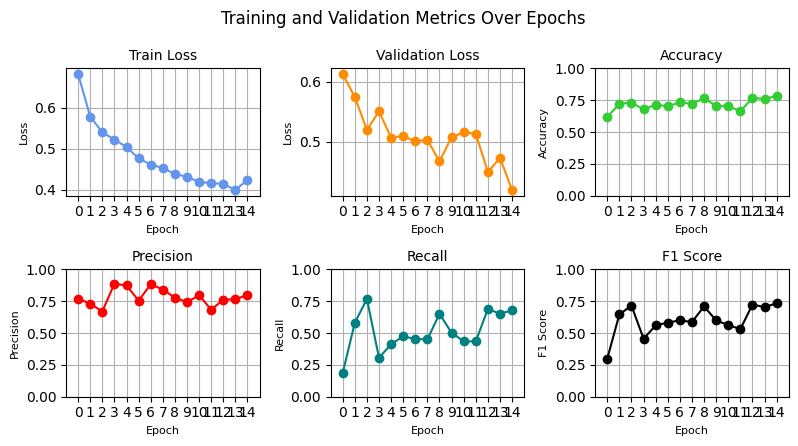

In [22]:
train(epochs=15)

Save the model if it achieves great results.

In [25]:
# Name convention: modeltype  _  train-set-length  _  test-set-length  _  accuracy  _  regularization  .pth
model_name = 'gnn_20000_20000_0.77_0.02.pth'
torch.save(model.state_dict(), PATH_MODELS + model_name)

----
## Testing

In this part, the models can be tested on any data available to check their generalization abilities and overall performance on previously unseen data.

In [ ]:
model = torch.load(PATH_MODELS + 'gnn_20000_5000_0-83.pth')
model.to('cuda')

------------------------------------------------------------
                       Test Results
------------------------------------------------------------
Average loss: 0.4218472519287322 
Accuracy: 0.78105 
Precision: 0.8011325333692868 
Recall: 0.6717160298439973 
F1: 0.7307384861341697 
Confusion matrix & ROC/AUC:



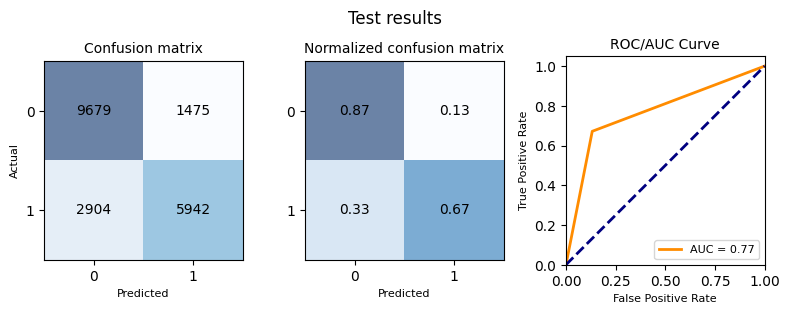

In [26]:
test_metrics = test(test_loader)

------------------------------------------------------------
                       Test Results
------------------------------------------------------------
Average loss: 0.4200393941428051 
Accuracy: 0.7812333333333333 
Precision: 0.8035294117647059 
Recall: 0.6690528219425815 
F1: 0.7301508984005592 
Confusion matrix & ROC/AUC:



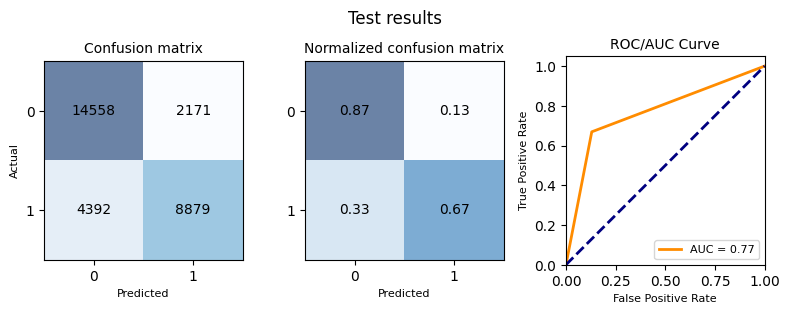

In [27]:
test_loader = DataLoader(shuffled_dataset[90000:120000], batch_size=1, shuffle=False)
test_metrics = test(test_loader)